# Predicting the outcome soccer matches using Machine Learning

## Đinh Bá Duy - 2010179
## Lê Đức Minh Nhật - 2013994

## Các thư viện sử dụng

Import các thư viện hỗ trợ trong chương trình, cũng như các mô hình máy học

In [27]:
from time import time
import numpy as np
import pandas as pd
import sqlite3
import warnings

warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold

# Tiến hành huấn luyện

## Phân tích dữ liệu

### Trích xuất dữ liệu từ cơ sở dữ liệu

In [28]:
with sqlite3.connect("dataset/database.sqlite") as con:
    matches = pd.read_sql_query("SELECT * from Match", con)
    team_attributes = pd.read_sql_query("SELECT distinct * from Team_Attributes", con)
    player = pd.read_sql_query("SELECT * from Player", con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)

### Trích xuất dữ liệu từ Matches

In [29]:
''' Derives a label for a given match. '''
def get_match_outcome(match):
    # Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']

    outcome = pd.DataFrame()  # Create a new dataframe: outcome
    outcome.loc[0, 'match_api_id'] = match['match_api_id']  # Insert match_api_id into outcome

    # Identify match outcome
    if home_goals > away_goals:
        outcome.loc[0, 'outcome'] = "Win"
    if home_goals == away_goals:
        outcome.loc[0, 'outcome'] = "Draw"
    if home_goals < away_goals:
        outcome.loc[0, 'outcome'] = "Defeat"

    # Return outcome
    return outcome.loc[0]


''' Get the last x matches of a given team. '''
def get_last_matches(matches, date, team, x=10):
    # Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]

    # Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by='date', ascending=False).iloc[0:x, :]

    # Return last matches
    return last_matches


''' Get the last team stats of a given team. '''
def get_last_team_stats(team_id, date, teams_stats):
    # Filter team stats
    all_team_stats = teams_stats[teams_stats['team_api_id'] == team_id]

    # Filter last stats from team
    last_team_stats = all_team_stats[all_team_stats.date < date].sort_values(by='date', ascending=False)
    if last_team_stats.empty:
        last_team_stats = all_team_stats[all_team_stats.date > date].sort_values(by='date', ascending=True)

    # Return last matches
    return last_team_stats.iloc[0:1, :]


''' Get the last x matches of two given teams. '''
def get_last_matches_against_eachother(matches, date, home_team, away_team, x=10):
    # Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]
    total_matches = pd.concat([home_matches, away_matches])

    # Get last x matches
    try:
        last_matches = total_matches[total_matches.date < date].sort_values(by='date', ascending=False).iloc[0:x, :]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by='date', ascending=False).iloc[
                       0:total_matches.shape[0], :]

        # Check for error in data
        if (last_matches.shape[0] > x):
            print("Error in obtaining matches")

    # Return data
    return last_matches


''' Get the goals[home & away] of a specfic team from a set of matches. '''
def get_goals(matches, team):
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    return total_goals


''' Get the goals[home & away] conceided of a specfic team from a set of matches. '''
def get_goals_conceided(matches, team):
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    return total_goals


''' Get the number of wins of a specfic team from a set of matches. '''
def get_wins(matches, team):
    # Find home and away wins
    home_wins = int(matches.home_team_goal[
                        (matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[
                        (matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    return total_wins


''' Create match specific features for a given match. '''
def get_match_features(match, matches, teams_stats, x=10):
    # Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id

    # Gets home and away team_stats
    home_team_stats = get_last_team_stats(home_team, date, teams_stats);
    away_team_stats = get_last_team_stats(away_team, date, teams_stats);

    # Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x=5)
    matches_away_team = get_last_matches(matches, date, away_team, x=5)

    # Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x=3)

    # Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)

    # Define result data frame
    result = pd.DataFrame()

    # Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id

    # Create match features and team stats
    if not home_team_stats.empty:
        result.loc[0, 'home_team_buildUpPlaySpeed'] = home_team_stats['buildUpPlaySpeed'].values[0]
        result.loc[0, 'home_team_buildUpPlayPassing'] = home_team_stats['buildUpPlayPassing'].values[0]
        result.loc[0, 'home_team_chanceCreationPassing'] = home_team_stats['chanceCreationPassing'].values[0]
        result.loc[0, 'home_team_chanceCreationCrossing'] = home_team_stats['chanceCreationCrossing'].values[0]
        result.loc[0, 'home_team_chanceCreationShooting'] = home_team_stats['chanceCreationShooting'].values[0]
        result.loc[0, 'home_team_defencePressure'] = home_team_stats['defencePressure'].values[0]
        result.loc[0, 'home_team_defenceAggression'] = home_team_stats['defenceAggression'].values[0]
        result.loc[0, 'home_team_defenceTeamWidth'] = home_team_stats['defenceTeamWidth'].values[0]
        result.loc[0, 'home_team_avg_shots'] = home_team_stats['avg_shots'].values[0]
        result.loc[0, 'home_team_avg_corners'] = home_team_stats['avg_corners'].values[0]
        result.loc[0, 'home_team_avg_crosses'] = away_team_stats['avg_crosses'].values[0]

    if (not away_team_stats.empty):
        result.loc[0, 'away_team_buildUpPlaySpeed'] = away_team_stats['buildUpPlaySpeed'].values[0]
        result.loc[0, 'away_team_buildUpPlayPassing'] = away_team_stats['buildUpPlayPassing'].values[0]
        result.loc[0, 'away_team_chanceCreationPassing'] = away_team_stats['chanceCreationPassing'].values[0]
        result.loc[0, 'away_team_chanceCreationCrossing'] = away_team_stats['chanceCreationCrossing'].values[0]
        result.loc[0, 'away_team_chanceCreationShooting'] = away_team_stats['chanceCreationShooting'].values[0]
        result.loc[0, 'away_team_defencePressure'] = away_team_stats['defencePressure'].values[0]
        result.loc[0, 'away_team_defenceAggression'] = away_team_stats['defenceAggression'].values[0]
        result.loc[0, 'away_team_defenceTeamWidth'] = away_team_stats['defenceTeamWidth'].values[0]
        result.loc[0, 'away_team_avg_shots'] = away_team_stats['avg_shots'].values[0]
        result.loc[0, 'away_team_avg_corners'] = away_team_stats['avg_corners'].values[0]
        result.loc[0, 'away_team_avg_crosses'] = away_team_stats['avg_crosses'].values[0]

    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team)
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    result.loc[0, 'B365H'] = match.B365H
    result.loc[0, 'B365D'] = match.B365D
    result.loc[0, 'B365A'] = match.B365A

    # Return match features
    return result.loc[0]


''' Create and aggregate features and labels for all matches. '''
def get_features(matches, teams_stats, fifa, x=10, get_overall=False):
    # Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)

    # Get match features for all matches
    match_stats = matches.apply(lambda i: get_match_features(i, matches, teams_stats, x=10), axis=1)

    # Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns=lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis=1)
    match_stats.drop(['league_id'], inplace=True, axis=1)

    # Create match outcomes
    outcomes = matches.apply(get_match_outcome, axis=1)

    # Merges features and outcomes into one frame
    features = pd.merge(match_stats, fifa_stats, on='match_api_id', how='left')
    features = pd.merge(features, outcomes, on='match_api_id', how='left')

    # Drop NA values
    features.dropna(inplace=True)

    # Return preprocessed data
    return features

''' Get overall fifa rankings from fifa data. '''
def get_overall_fifa_rankings(fifa, get_overall=False):
    
    temp_data = fifa

    # Check if only overall player stats are desired
    if get_overall == True:

        # Get overall stats
        data = temp_data.loc[:, (fifa.columns.str.contains('overall_rating'))]
        data.loc[:, 'match_api_id'] = temp_data.loc[:, 'match_api_id']
    else:

        # Get all stats except for stat date
        cols = fifa.loc[:, (fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis=1)
        data = temp_data

    # Return data
    return data

Chọn lọc người dự đoán có số lượng dữ liệu dự đoán nhiều nhất từ dữ liệu có sẵn

In [30]:
viable_matches = matches.sample(n=5000)
b365 = viable_matches.dropna(subset=['B365H', 'B365D', 'B365A'], inplace=False)
b365.drop(['BWH', 'BWD', 'BWA',
           'IWH', 'IWD', 'IWA',
           'LBH', 'LBD', 'LBA',
           'PSH', 'PSD', 'PSA',
           'WHH', 'WHD', 'WHA',
           'SJH', 'SJD', 'SJA',
           'VCH', 'VCD', 'VCA',
           'GBH', 'GBD', 'GBA',
           'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

bw = viable_matches.dropna(subset=['BWH', 'BWD', 'BWA'], inplace=False)
bw.drop(['B365H', 'B365D', 'B365A',
         'IWH', 'IWD', 'IWA',
         'LBH', 'LBD', 'LBA',
         'PSH', 'PSD', 'PSA',
         'WHH', 'WHD', 'WHA',
         'SJH', 'SJD', 'SJA',
         'VCH', 'VCD', 'VCA',
         'GBH', 'GBD', 'GBA',
         'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

iw = viable_matches.dropna(subset=['IWH', 'IWD', 'IWA'], inplace=False)
iw.drop(['B365H', 'B365D', 'B365A',
         'BWH', 'BWD', 'BWA',
         'LBH', 'LBD', 'LBA',
         'PSH', 'PSD', 'PSA',
         'WHH', 'WHD', 'WHA',
         'SJH', 'SJD', 'SJA',
         'VCH', 'VCD', 'VCA',
         'GBH', 'GBD', 'GBA',
         'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

lb = viable_matches.dropna(subset=['LBH', 'LBD', 'LBA'], inplace=False)
lb.drop(['B365H', 'B365D', 'B365A',
         'BWH', 'BWD', 'BWA',
         'IWH', 'IWD', 'IWA',
         'PSH', 'PSD', 'PSA',
         'WHH', 'WHD', 'WHA',
         'SJH', 'SJD', 'SJA',
         'VCH', 'VCD', 'VCA',
         'GBH', 'GBD', 'GBA',
         'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

ps = viable_matches.dropna(subset=['PSH', 'PSD', 'PSA'], inplace=False)
ps.drop(['B365H', 'B365D', 'B365A',
         'BWH', 'BWD', 'BWA',
         'IWH', 'IWD', 'IWA',
         'LBH', 'LBD', 'LBA',
         'WHH', 'WHD', 'WHA',
         'SJH', 'SJD', 'SJA',
         'VCH', 'VCD', 'VCA',
         'GBH', 'GBD', 'GBA',
         'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

wh = viable_matches.dropna(subset=['WHH', 'WHD', 'WHA'], inplace=False)
wh.drop(['B365H', 'B365D', 'B365A',
         'BWH', 'BWD', 'BWA',
         'IWH', 'IWD', 'IWA',
         'LBH', 'LBD', 'LBA',
         'PSH', 'PSD', 'PSA',
         'SJH', 'SJD', 'SJA',
         'VCH', 'VCD', 'VCA',
         'GBH', 'GBD', 'GBA',
         'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

sj = viable_matches.dropna(subset=['SJH', 'SJD', 'SJA'], inplace=False)
sj.drop(['B365H', 'B365D', 'B365A',
         'BWH', 'BWD', 'BWA',
         'IWH', 'IWD', 'IWA',
         'LBH', 'LBD', 'LBA',
         'PSH', 'PSD', 'PSA',
         'WHH', 'WHD', 'WHA',
         'VCH', 'VCD', 'VCA',
         'GBH', 'GBD', 'GBA',
         'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

vc = viable_matches.dropna(subset=['VCH', 'VCD', 'VCA'], inplace=False)
vc.drop(['B365H', 'B365D', 'B365A',
         'BWH', 'BWD', 'BWA',
         'IWH', 'IWD', 'IWA',
         'LBH', 'LBD', 'LBA',
         'PSH', 'PSD', 'PSA',
         'WHH', 'WHD', 'WHA',
         'SJH', 'SJD', 'SJA',
         'GBH', 'GBD', 'GBA',
         'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

gb = viable_matches.dropna(subset=['GBH', 'GBD', 'GBA'], inplace=False)
gb.drop(['B365H', 'B365D', 'B365A',
         'BWH', 'BWD', 'BWA',
         'IWH', 'IWD', 'IWA',
         'LBH', 'LBD', 'LBA',
         'PSH', 'PSD', 'PSA',
         'WHH', 'WHD', 'WHA',
         'SJH', 'SJD', 'SJA',
         'VCH', 'VCD', 'VCA',
         'BSH', 'BSD', 'BSA'], inplace=True, axis=1)

bs = viable_matches.dropna(subset=['BSH', 'BSD', 'BSA'], inplace=False)
bs.drop(['B365H', 'B365D', 'B365A',
         'BWH', 'BWD', 'BWA',
         'IWH', 'IWD', 'IWA',
         'LBH', 'LBD', 'LBA',
         'PSH', 'PSD', 'PSA',
         'WHH', 'WHD', 'WHA',
         'SJH', 'SJD', 'SJA',
         'VCH', 'VCD', 'VCA',
         'GBH', 'GBD', 'GBA'], inplace=True, axis=1)

lis = [b365, bw, iw, lb, ps, wh, sj, vc, gb, bs]

viable_matches = max(lis, key=lambda datframe: datframe.shape[0])

Loại bỏ các hàng dữ liệu không chứa thông tin nào về vị trí của 
cầu thủ trong một trận đấu

In [31]:
teams_stats = team_attributes
viable_matches = viable_matches.dropna(inplace=False)

home_teams = viable_matches['home_team_api_id'].isin(teams_stats['team_api_id'].tolist())
away_teams = viable_matches['away_team_api_id'].isin(teams_stats['team_api_id'].tolist())
viable_matches = viable_matches[home_teams & away_teams]

### Xử lí dữ liệu về các thuộc tính đội trong một trận đấu

#### Thuộc tính buildUpPlayDribbling

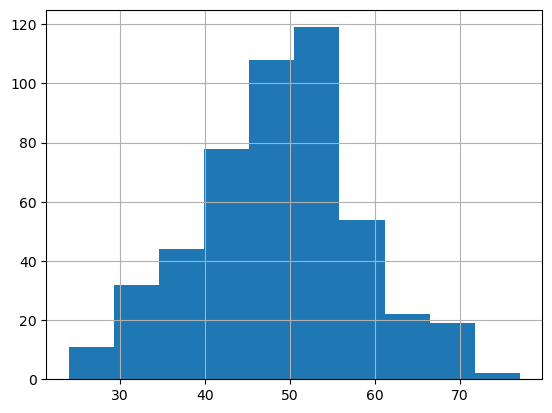

In [32]:
teams_stats['buildUpPlayDribbling'].hist();

Hầu hết các giá trị của buildUpPlayDribbling nằm trong khoảng 45 - 55, vì vậy chúng ta hãy điền các giá trị Nan này bằng tốc độ buildUpPlaySpeed trung bình được đo.

In [33]:
build_up_play_drib_avg = teams_stats['buildUpPlayDribbling'].mean()

teams_stats.loc[(teams_stats['buildUpPlayDribbling'].isnull()), 'buildUpPlayDribbling'] = build_up_play_drib_avg

Chọn lựa các cột chứa giá trị là số để làm đầu vào cho mô hình học máy

In [34]:
teams_stats.drop(['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass', 
    'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass',  
    'chanceCreationShootingClass','chanceCreationPositioningClass','defencePressureClass', 'defenceAggressionClass', 
    'defenceTeamWidthClass','defenceDefenderLineClass'], inplace = True, axis = 1)

#### Thuộc tính avg_shots

Tính toán và kết hợp vào bộ dữ liệu đầu

In [35]:
shots_off = pd.read_csv("dataset/shotoff_detail.csv")
shots_on = pd.read_csv("dataset/shoton_detail.csv")
shots = pd.concat([shots_off[['match_id', 'team']], shots_on[['match_id', 'team']]])

total_shots = shots["team"].value_counts()
total_matches = shots.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_shots in total_shots.items():
    n_matches = total_matches[index]
    avg_shots = n_shots / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_shots'] = avg_shots

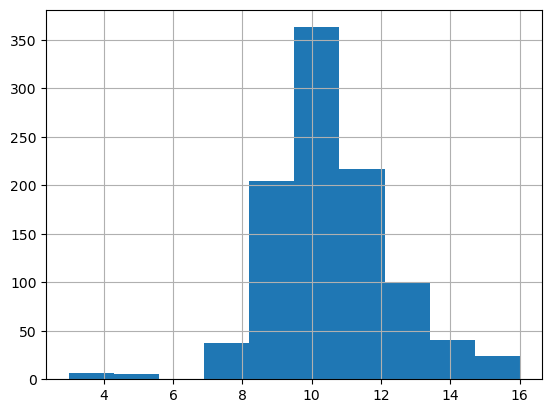

In [36]:
teams_stats['avg_shots'].hist();

Hầu hết các giá trị avg_shots nằm trong phạm vi 7 - 14, vì vậy hãy điền các giá trị Nan này bằng giá trị trung bình được đo đạc của avg_shots.

In [37]:
shots_avg_team_avg = teams_stats['avg_shots'].mean()

teams_stats.loc[(teams_stats['avg_shots'].isnull()), 'avg_shots'] = shots_avg_team_avg

#### Thuộc tính corners

Kết hợp dữ liệu corners trong cơ sở dữ liệu vào bộ dữ liệu đầu vào

In [38]:
corners_data = pd.read_csv("dataset/corner_detail.csv")
corners = corners_data[['match_id', 'team']]

total_corners = corners["team"].value_counts()
total_matches = corners.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_corners in total_shots.items():
    n_matches = total_matches[index]
    avg_corners = n_corners / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_corners'] = avg_corners

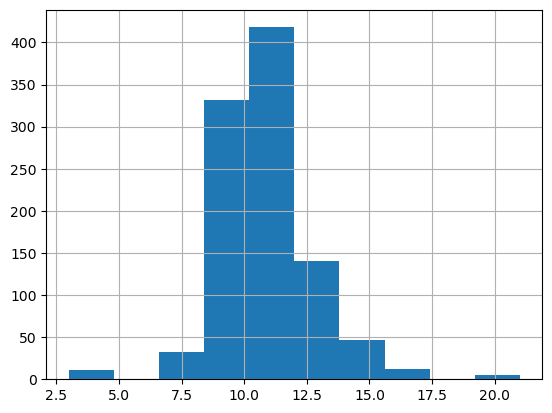

In [39]:
teams_stats['avg_corners'].hist();

Chúng ta có thể thấy rằng hầu hết các giá trị avg_corners nằm trong khoảng 8.5 - 12, vì vậy sẽ điền các mục có giá trị Nan này bằng giá trị trung bình của avg_corners đã đo được.

In [40]:
corners_avg_team_avg = teams_stats['avg_corners'].mean()

teams_stats.loc[(teams_stats['avg_corners'].isnull()), 'avg_corners'] = corners_avg_team_avg

#### Thuộc tính crosses

Kết hợp dữ liệu cross trong cơ sở dữ liệu vào bộ dữ liệu làm đầu vào

In [41]:
crosses_data = pd.read_csv("dataset/cross_detail.csv")

crosses = crosses_data[['match_id', 'team']]
total_crosses = crosses["team"].value_counts()
total_matches = crosses.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_crosses in total_crosses.items():
    n_matches = total_matches[index]
    avg_crosses = n_crosses / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_crosses'] = avg_crosses

teams_stats['avg_crosses'].hist();

Bảng dữ liệu của thuộc tính cross cũng sẽ có những hàng dữ liệu bị khuyết giá trị. Có thể thấy rằng hầu hết các giá trị avg_crosses nằm trong khoảng 12.5 - 17.5, vì vậy sẽ điền các mục này bằng giá trị trung bình của avg_crosses đã đo được.

In [42]:
crosses_avg_team_avg = teams_stats['avg_crosses'].mean()

teams_stats.loc[(teams_stats['avg_crosses'].isnull()), 'avg_crosses'] = crosses_avg_team_avg

### Xử lí dữ liệu của FIFA

In [43]:
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        #Get player ID
        player_id = match[player]
        
        #Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        #Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Return player stats    
    return player_stats_new.iloc[0]    


def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    #Check if fifa data already exists
    if data_exists == True:
        fifa_data = pd.read_pickle(path)
        
    else:
        print("Collecting fifa data for each match...")       
        start = time()
        
        #Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    #Return fifa_data
    return fifa_data

In [44]:
fifa_data = get_fifa_data(viable_matches, player_attributes, None, data_exists = False)
fifa_data.describe()

Fifa data collected in 1.3 minutes


,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,home_player_5_overall_rating,home_player_6_overall_rating,home_player_7_overall_rating,home_player_8_overall_rating,home_player_9_overall_rating,home_player_10_overall_rating,...,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,match_api_id
count,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,...,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2.582000e+03
mean,76.137103,72.714562,74.694810,74.491479,72.553447,74.386522,74.331139,74.348954,75.224245,75.599148,...,74.778079,74.536793,72.615802,74.295120,74.440356,74.449651,75.050736,75.602634,75.713400,1.263737e+06
std,5.392443,5.166002,4.885893,5.262844,5.133028,5.107836,5.178034,5.285517,5.229975,5.535631,...,5.023688,5.402441,5.015855,5.260628,5.195978,5.340805,5.556527,5.751010,5.466743,4.874634e+05
min,43.000000,51.000000,57.000000,48.000000,52.000000,51.000000,51.000000,51.000000,55.000000,53.000000,...,56.000000,54.000000,51.000000,51.000000,50.000000,54.000000,51.000000,54.000000,55.000000,4.890540e+05
25%,73.000000,70.000000,72.000000,72.000000,69.000000,71.000000,71.000000,71.000000,72.000000,72.000000,...,72.000000,71.000000,70.000000,71.000000,71.000000,71.000000,72.000000,72.000000,72.000000,8.570322e+05
50%,76.000000,73.000000,75.000000,75.000000,73.000000,74.000000,74.000000,74.000000,75.000000,75.000000,...,75.000000,74.000000,73.000000,74.000000,74.000000,74.000000,75.000000,75.000000,75.000000,1.239478e+06
75%,80.000000,76.000000,78.000000,78.000000,76.000000,78.000000,77.750000,78.000000,78.000000,79.000000,...,78.000000,78.000000,76.000000,78.000000,78.000000,78.000000,79.000000,79.000000,79.000000,1.712693e+06
max,91.000000,88.000000,89.000000,89.000000,90.000000,92.000000,92.000000,90.000000,94.000000,94.000000,...,89.000000,89.000000,87.000000,91.000000,91.000000,91.000000,94.000000,94.000000,93.000000,2.060645e+06


### Tổng hợp các dữ liệu vào bộ dữ liệu làm đầu vào

In [45]:
viables = get_features(viable_matches, teams_stats, fifa_data, 10, False)
inputs = viables.drop('match_api_id', axis=1)
outcomes = inputs.loc[:, 'outcome']

features = inputs.drop('outcome', axis=1)
features.iloc[:,:] = Normalizer(norm='l1').fit_transform(features)
features.head()

,home_team_buildUpPlaySpeed,home_team_buildUpPlayPassing,home_team_chanceCreationPassing,home_team_chanceCreationCrossing,home_team_chanceCreationShooting,home_team_defencePressure,home_team_defenceAggression,home_team_defenceTeamWidth,home_team_avg_shots,home_team_avg_corners,...,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating
0,0.024174,0.011332,0.024552,0.018886,0.026441,0.026441,0.012843,0.020775,0.004215,0.004258,...,0.026441,0.029085,0.027574,0.027952,0.026441,0.028329,0.026441,0.027196,0.027952,0.029085
1,0.024032,0.026745,0.015892,0.024419,0.021706,0.018218,0.021319,0.020156,0.004249,0.004419,...,0.027520,0.028683,0.028295,0.027133,0.027908,0.029846,0.028683,0.029458,0.027908,0.028683
2,0.025372,0.014668,0.015065,0.019426,0.020219,0.014272,0.024976,0.019426,0.004142,0.004182,...,0.029733,0.028148,0.030130,0.027355,0.027751,0.029337,0.028148,0.032112,0.025769,0.028940
3,0.008943,0.009316,0.013787,0.008943,0.020122,0.024594,0.023476,0.024594,0.004991,0.005013,...,0.027575,0.026084,0.025712,0.026830,0.027575,0.027202,0.026830,0.027202,0.025712,0.027575
4,0.016001,0.014830,0.016001,0.023026,0.024197,0.022636,0.019904,0.021855,0.005636,0.005654,...,0.028100,0.028880,0.030441,0.027709,0.028880,0.029661,0.030441,0.028880,0.029270,0.030051


## Tiến hành phân loại & Đánh giá

### Một số hàm hỗ trợ

In [46]:
def convert_xgb_labels(labels):
    xgb_labels = labels.copy()
    for i in range(len(xgb_labels)):
        if xgb_labels[i] == 'Win':
            xgb_labels[i] = 0
        elif xgb_labels[i] == 'Draw':
            xgb_labels[i] = 1
        else:
            xgb_labels[i] = 2
    return xgb_labels

def convert_xgb_y_predict(y_predict):
    mapping_dict = {0: 'Win', 1: 'Draw', 2: 'Defeat'}
    y_predict = np.array([mapping_dict[value] for value in y_predict], dtype=object)
    return y_predict

def train_predict(clf, data, outcomes):
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(data)))
    if clf.__class__.__name__ == 'XGBClassifier':
        xgb_outcomes = convert_xgb_labels(outcomes)
        y_predict = train_model(clf, data, xgb_outcomes)
        predict_metrics(outcomes, convert_xgb_y_predict(y_predict))
    else:
        y_predict = train_model(clf, data, outcomes)
        predict_metrics(outcomes, y_predict)

def train_model(clf, data, labels):
    kf = KFold(n_splits=5)
    predictions = []
    for train, test in kf.split(data):
        X_train, X_test = data[data.index.isin(train)], data[data.index.isin(test)]
        y_train, y_test = labels[data.index.isin(train)], labels[data.index.isin(test)]
        clf.fit(X_train, y_train)
        predictions.append(clf.predict(X_test))

    y_predict = predictions[0]
    y_predict = np.append(y_predict, predictions[1], axis=0)
    y_predict = np.append(y_predict, predictions[2], axis=0)
    y_predict = np.append(y_predict, predictions[3], axis=0)
    y_predict = np.append(y_predict, predictions[4], axis=0)

    return y_predict

def predict_metrics(y_test, y_predict):
    ls = ['Win', 'Draw', 'Defeat']
    from sklearn import metrics

    print(metrics.classification_report(y_test, y_predict, target_names=ls))
    print("Accuracy: ", metrics.accuracy_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict, average='macro'))
    print("Precision: ", metrics.precision_score(y_test, y_predict, average='macro', zero_division=0))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict, average='macro'))
    print("-----------------------------------")

### Huấn luyện mô hình

#### Mô hình phân loại K-Nearest Neighbors

In [47]:
clf = KNeighborsClassifier(n_neighbors=90)
train_predict(clf, features, outcomes)

Training a KNeighborsClassifier using a training set size of 2582. . .
              precision    recall  f1-score   support

         Win       0.50      0.38      0.43       726
        Draw       0.28      0.02      0.03       647
      Defeat       0.53      0.88      0.66      1209

    accuracy                           0.52      2582
   macro avg       0.44      0.43      0.38      2582
weighted avg       0.46      0.52      0.44      2582

Accuracy:  0.5216886134779241
Recall:  0.4250644105353638
Precision:  0.43799508314819485
F1 Score:  0.37682746656170013
-----------------------------------


#### Mô hình phân loại Decision Tree

In [48]:
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', splitter='random', max_depth=5)
train_predict(clf, features, outcomes)

Training a DecisionTreeClassifier using a training set size of 2582. . .
              precision    recall  f1-score   support

         Win       0.49      0.39      0.43       726
        Draw       0.19      0.01      0.02       647
      Defeat       0.53      0.87      0.66      1209

    accuracy                           0.52      2582
   macro avg       0.40      0.42      0.37      2582
weighted avg       0.44      0.52      0.44      2582

Accuracy:  0.5193648334624322
Recall:  0.4233693315718634
Precision:  0.40465387662572105
F1 Score:  0.37322284261283306
-----------------------------------


#### Mô hình phân loại Random Forest

In [49]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
train_predict(clf, features, outcomes)

Training a RandomForestClassifier using a training set size of 2582. . .
              precision    recall  f1-score   support

         Win       0.51      0.45      0.48       726
        Draw       0.29      0.07      0.11       647
      Defeat       0.56      0.82      0.66      1209

    accuracy                           0.53      2582
   macro avg       0.45      0.45      0.42      2582
weighted avg       0.48      0.53      0.47      2582

Accuracy:  0.5286599535243997
Recall:  0.44741244252636775
Precision:  0.4499482501783116
F1 Score:  0.4176014261941034
-----------------------------------


#### Mô hình phân loại Support Vector Machines

In [50]:
clf = SVC(coef0=5, kernel='poly')
train_predict(clf, features, outcomes)

Training a SVC using a training set size of 2582. . .
              precision    recall  f1-score   support

         Win       0.55      0.42      0.48       726
        Draw       0.00      0.00      0.00       647
      Defeat       0.54      0.90      0.68      1209

    accuracy                           0.54      2582
   macro avg       0.36      0.44      0.38      2582
weighted avg       0.41      0.54      0.45      2582

Accuracy:  0.5414407436096049
Recall:  0.44157113658579933
Precision:  0.3621626395365268
F1 Score:  0.3839486544858734
-----------------------------------


#### Mô hình phân loại Naive Bayes

In [51]:
clf = GaussianNB(var_smoothing=1.1)
train_predict(clf, features, outcomes)

Training a GaussianNB using a training set size of 2582. . .
              precision    recall  f1-score   support

         Win       0.49      0.51      0.50       726
        Draw       0.39      0.05      0.08       647
      Defeat       0.57      0.81      0.67      1209

    accuracy                           0.54      2582
   macro avg       0.48      0.46      0.42      2582
weighted avg       0.50      0.54      0.47      2582

Accuracy:  0.5367931835786213
Recall:  0.4575534424918226
Precision:  0.48206792335322435
F1 Score:  0.41636671990590424
-----------------------------------


#### Mô hình phân loại Gradient Boosting

In [52]:
clf = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)
train_predict(clf, features, outcomes)

Training a XGBClassifier using a training set size of 2582. . .
              precision    recall  f1-score   support

         Win       0.52      0.45      0.48       726
        Draw       0.28      0.08      0.13       647
      Defeat       0.56      0.81      0.66      1209

    accuracy                           0.53      2582
   macro avg       0.45      0.45      0.42      2582
weighted avg       0.48      0.53      0.48      2582

Accuracy:  0.5271107668474051
Recall:  0.44773129081939883
Precision:  0.45227104337011453
F1 Score:  0.4231100965626955
-----------------------------------
